In [1]:
import os
import glob2
from IPython.display import Image, display
import pandas as pd
import pipeline as pl  # import the functions from our pipeline
import sklearn.preprocessing

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
os.getcwd()

'C:\\Users\\edwar.WJM-SONYLAPTOP\\Documents\\GitHub\\ML_spring_2019\\exercise five'

# Working with the project grant database

In [3]:
projects = pl.load_and_peek_at_data('raw data/projects_2012_2013.csv',
                                 date_vars=['date_posted', 'datefullyfunded'],
                                 summary=True)

************************
************************


Head of data:
                          projectid                    teacher_acctid  \
0  00001ccc0e81598c4bd86bacb94d7acb  96963218e74e10c3764a5cfb153e6fea   
1  0000fa3aa8f6649abab23615b546016d  2a578595fe351e7fce057e048c409b18   
2  000134f07d4b30140d63262c871748ff  26bd60377bdbffb53a644a16c5308e82   
3  0001f2d0b3827bba67cdbeaa248b832d  15d900805d9d716c051c671827109f45   
4  0004536db996ba697ca72c9e058bfe69  400f8b82bb0143f6a40b217a517fe311   

                           schoolid  school_ncesid  school_latitude  \
0  9f3f9f2c2da7edda5648ccd10554ed8c   1.709930e+11        41.807654   
1  3432ed3d4466fac2f2ead83ab354e333   6.409801e+10        34.296596   
2  dc8dcb501c3b2bb0b10e9c6ee2cd8afd   6.227100e+10        34.078625   
3  8bea7e8c6e4279fca6276128db89292e   3.600090e+11        40.687286   
4  fbdefab6fe41e12c55886c610c110753   3.606870e+11        40.793018   

   school_longitude    school_city school_state school_metro  \
0   

## Look at graphs of our data

skew  for col  school_ncesid is: 0.2711573604703356


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


skew  for col  school_latitude is: 0.1440819241196608
skew  for col  school_longitude is: -0.5499588442758634
skew  for col  total_price_including_optional_support is: 51.28723385273174
skew  for col  students_reached is: 8.40562677720166


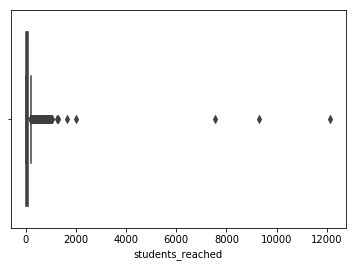

In [4]:
pl.make_graphs(projects, normal_qq_plots=False)

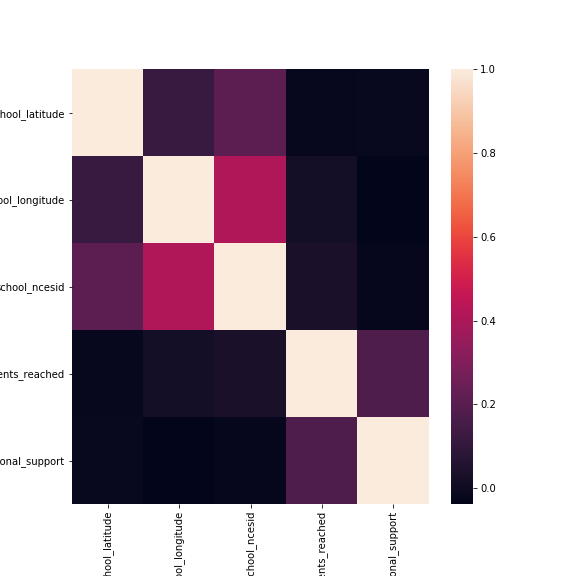

figures\correlation_plot.png


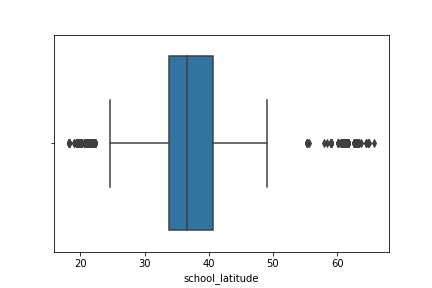

figures\school_latitude boxplot.png


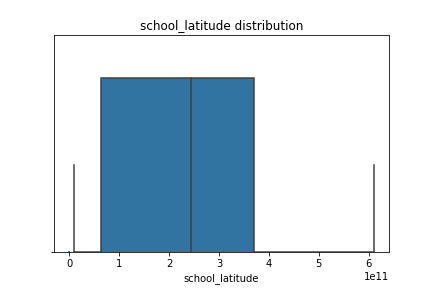

figures\school_latitude.png


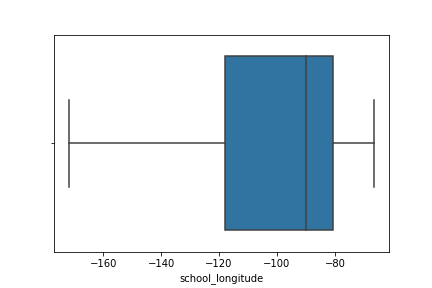

figures\school_longitude boxplot.png


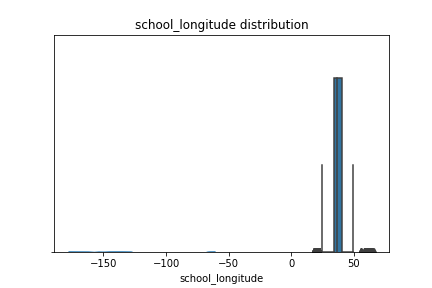

figures\school_longitude.png


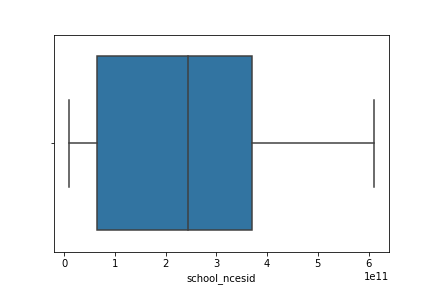

figures\school_ncesid boxplot.png


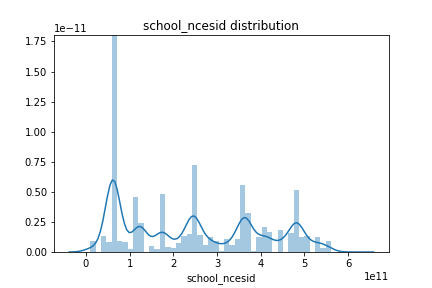

figures\school_ncesid.png


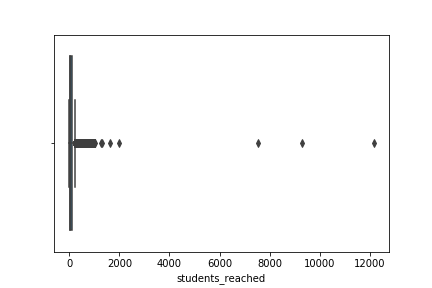

figures\students_reached boxplot.png


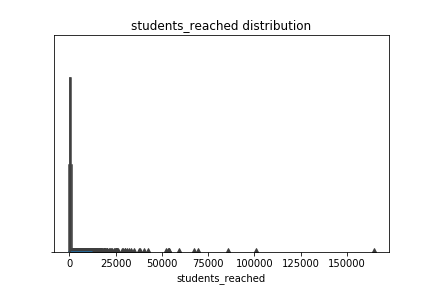

figures\students_reached.png


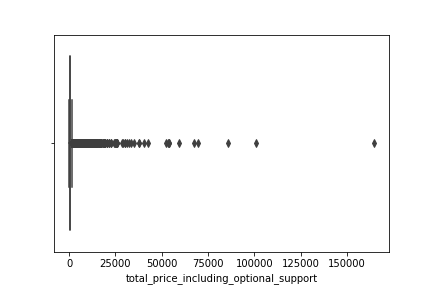

figures\total_price_including_optional_support boxplot.png


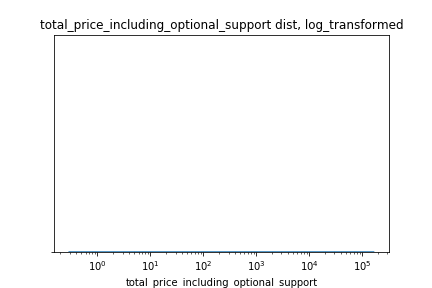

figures\total_price_including_optional_supportlog_transformed.png


In [5]:
for imageName in glob2.glob('figures/*.png'):
    display(Image(filename=imageName))
    print(imageName)

In [6]:
# make dummy vars
cat_vars = ['primary_focus_subject', 'secondary_focus_area', 'secondary_focus_subject',
            'school_metro', 'school_charter', 'school_magnet',
           'primary_focus_area', 'resource_type', 'poverty_level', 'grade_level',
           'eligible_double_your_impact_match']

In [7]:
# make dummy outcome var
projects['60_day_outcome'] = (projects['datefullyfunded'] -
                              projects['date_posted']) > pd.Timedelta('60 days')

In [8]:
# #make dummy vars
# for var in cat_vars:
#     projects = pl.make_dummies(projects, var)
# # take a subset of our features
# new_cat_vars = [col for col in projects if col.startswith('D_')]
# vars_to_keep = new_cat_vars + ['date_posted', 'students_reached',
#                                'total_price_including_optional_support', '60_day_outcome']
# projects = projects[vars_to_keep]

# Make test and training sets

In [9]:
test_set_ranges = [('2012-01-01', '2012-04-30', '2012-07-01', '2012-10-31'), 
                   ('2012-01-01', '2012-10-31', '2013-01-01', '2013-04-30'), 
                   ('2012-01-01', '2013-04-30', '2013-07-01', '2013-10-31')]

In [10]:
# defining variables to keep, making dummies
def make_dummies_subset_df(df, cat_vars, vars_to_keep):
    #make dummy vars
    for var in cat_vars:
        df = pl.make_dummies(df, var)
    # take a subset of our features
    new_cat_vars = [col for col in df if col.startswith('D_')]
    vars_to_keep = new_cat_vars + ['date_posted', 'students_reached',
                                   'total_price_including_optional_support', '60_day_outcome']
    
    return df[vars_to_keep]

In [11]:
vars_to_keep = ['date_posted', 'students_reached',
                'total_price_including_optional_support', '60_day_outcome']

## First training/test split

In [12]:
date_subset = test_set_ranges[0]
train, test = pl.split_using_date(projects,
                               train_start_date=date_subset[0],
                               train_end_date=date_subset[1],
                               test_start_date=date_subset[2],
                               test_end_date=date_subset[3])
print('training start and end dates are ', date_subset[:2], '\ntraining data dimensions:', train.shape)

train = make_dummies_subset_df(train, cat_vars, vars_to_keep)
test = make_dummies_subset_df(test, cat_vars, vars_to_keep)

# Fill missing values
pl.fill_missing(train, imputation_method='median')
pl.fill_missing(test, imputation_method='median')

# Split our training and test sets into x and y variables:
x, x_t = (train.drop(['60_day_outcome', 'date_posted'], axis=1),
    test.drop(['60_day_outcome', 'date_posted'], axis=1))
scaling = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(x)
x_scaled = scaling.transform(x)
scaling = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(x_t)
x_t_scaled = scaling.transform(x_t)
y, y_t = (train['60_day_outcome'], test['60_day_outcome'])

print('mean of 60 day outcome in training set:', round(y.mean(), 2))

training start and end dates are  ('2012-01-01', '2012-04-30') 
training data dimensions: (21180, 27)
mean of 60 day outcome in training set: 0.32


************Bagged Tree
Returning test set performance:
Threshold:  0
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 17225]
 [    0  5706]]


Threshold:  1
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 17225]
 [    0  5706]]


Threshold:  2
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 17225]
 [    0  5706]]


Threshold:  5
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 1017 16208]
 [  120  5586]]


Threshold:  10
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 1333 15892]
 [  195  5511]]


Threshold:  20
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 3911 13314]
 [  671  5035]]


Threshold:  30
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 5659 11566]
 [ 1010  4696]]


Threshold:  50
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[9344 7881]
 [2121 3585]]


Threshold:  60
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[10986  6239]
 [ 2750  2956]]


Threshold:  70
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[12626  4599]
 [ 3399  2307]]


Th

confusion matrix
|T neg, F pos|
|F neg, T pos|
[[15868  1357]
 [ 4769   937]]


Threshold:  95
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[16586   639]
 [ 5198   508]]


Threshold:  98
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[16973   252]
 [ 5499   207]]


Threshold:  99
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[17113   112]
 [ 5588   118]]


Threshold:  100
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[17224     1]
 [ 5706     0]]


Threshold:  100
***************Tree model
Returning test set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 17225]
 [    0  5706]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 17225]
 [    0  5706]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 17225]
 [    0  5706]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 17225]
 [    0  5706]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 1996 15229]
 [  289  5417]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 3759 13466]
 [ 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


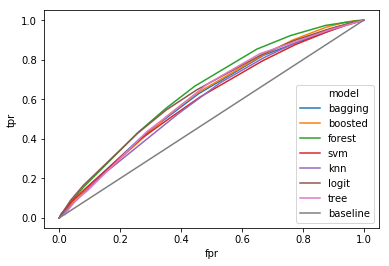

In [13]:
pl.compare_models(x_data=x, x_data_scaled=x_scaled, y_data=y,
               x_test=x_t, x_test_scaled=x_t_scaled,
               y_test=y_t, use_test_data=True,
               run_svm=True,
               run_tree=True,
               run_boosted=True, 
               run_bagging=True,
               run_logit=True,
               run_a_forest=True,
               run_knn=True,
               mythresholds=[0, 1, 2, 5, 10, 20, 30, 50, 60, 70, 90, 95, 98, 99, 100],
               my_max_depth=10,
               my_n_estimators=200,
               num_n=16,
               mykernel='linear',
               my_max_bagging_samples=200,
               my_svc_tol=.0000001,
               my_svc_random_state=0,
               my_svc_C=0.01,
               split_name="split_1_max_depth_10")

************Bagged Tree
Returning test set performance:
Threshold:  0
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 17225]
 [    0  5706]]


Threshold:  1
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 17225]
 [    0  5706]]


Threshold:  2
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 17225]
 [    0  5706]]


Threshold:  5
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[  996 16229]
 [  148  5558]]


Threshold:  10
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[  996 16229]
 [  148  5558]]


Threshold:  20
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 3574 13651]
 [  646  5060]]


Threshold:  30
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 3574 13651]
 [  646  5060]]


Threshold:  50
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 7111 10114]
 [ 1577  4129]]


Threshold:  60
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[10678  6547]
 [ 2788  2918]]


Threshold:  70
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[10678  6547]
 [ 2788  2918]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[11170  6055]
 [ 2588  3118]]


Threshold:  70
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[12790  4435]
 [ 3261  2445]]


Threshold:  90
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[15868  1357]
 [ 4769   937]]


Threshold:  95
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[16586   639]
 [ 5198   508]]


Threshold:  98
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[16973   252]
 [ 5499   207]]


Threshold:  99
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[17113   112]
 [ 5588   118]]


Threshold:  100
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[17224     1]
 [ 5706     0]]


Threshold:  100
***************Tree model
Returning test set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 17225]
 [    0  5706]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 17225]
 [    0  5706]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 17225]
 [    0  5706]]


confusion matrix
|T neg, F pos|
|F 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


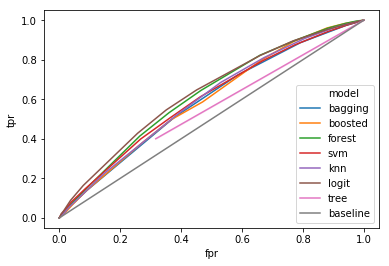

In [14]:
pl.compare_models(x_data=x, x_data_scaled=x_scaled, y_data=y,
               x_test=x_t, x_test_scaled=x_t_scaled,
               y_test=y_t, use_test_data=True,
               run_svm=True,
               run_tree=True,
               run_boosted=True, 
               run_bagging=True,
               run_logit=True,
               run_a_forest=True,
               run_knn=True,
               mythresholds=[0, 1, 2, 5, 10, 20, 30, 50, 60, 70, 90, 95, 98, 99, 100],
               my_max_depth=50,
               my_n_estimators=200,
               num_n=16,
               mykernel='linear',
               my_max_bagging_samples=200,
               my_svc_tol=.0000001,
               my_svc_random_state=0,
               my_svc_C=0.01,
               split_name="split_1_max_depth_50")

## Second training/test split

In [15]:
date_subset = test_set_ranges[1]
train, test = pl.split_using_date(projects,
                               train_start_date=date_subset[0],
                               train_end_date=date_subset[1],
                               test_start_date=date_subset[2],
                               test_end_date=date_subset[3])
print('training start and end dates are ', date_subset[:2], '\ntraining data dimensions:', train.shape)

train = make_dummies_subset_df(train, cat_vars, vars_to_keep)
test = make_dummies_subset_df(test, cat_vars, vars_to_keep)

# Fill missing values
pl.fill_missing(train, imputation_method='median')
pl.fill_missing(test, imputation_method='median')

# Split our training and test sets into x and y variables:
x, x_t = (train.drop(['60_day_outcome', 'date_posted'], axis=1),
         test.drop(['60_day_outcome', 'date_posted'], axis=1))
scaling = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(x)
x_scaled = scaling.transform(x)
scaling = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(x_t)
x_t_scaled = scaling.transform(x_t)
y, y_t = (train['60_day_outcome'], test['60_day_outcome'])

print('mean of 60 day outcome in training set:', round(y.mean(), 2))


training start and end dates are  ('2012-01-01', '2012-10-31') 
training data dimensions: (49680, 27)
mean of 60 day outcome in training set: 0.28


************Bagged Tree
Returning test set performance:
Threshold:  0
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 10422]
 [    0  4442]]


Threshold:  1
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 10422]
 [    0  4442]]


Threshold:  2
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[  231 10191]
 [   38  4404]]


Threshold:  5
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 627 9795]
 [ 116 4326]]


Threshold:  10
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 672 9750]
 [ 131 4311]]


Threshold:  20
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[2402 8020]
 [ 570 3872]]


Threshold:  30
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[2775 7647]
 [ 738 3704]]


Threshold:  50
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[5603 4819]
 [1818 2624]]


Threshold:  60
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[6693 3729]
 [2222 2220]]


Threshold:  70
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[7629 2793]
 [2771 1671]]


Threshold:  90
confusion m

confusion matrix
|T neg, F pos|
|F neg, T pos|
[[10289   133]
 [ 4277   165]]


Threshold:  99
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[10355    67]
 [ 4360    82]]


Threshold:  100
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[10422     0]
 [ 4441     1]]


Threshold:  100
***************Tree model
Returning test set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 10422]
 [    0  4442]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 10422]
 [    0  4442]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 10422]
 [    0  4442]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 526 9896]
 [  93 4349]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[1305 9117]
 [ 177 4265]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[2543 7879]
 [ 402 4040]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[3721 6701]
 [ 728 3714]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[5718 4704]
 [1354 3088]]


confusion matrix
|T neg, F pos|
|F 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


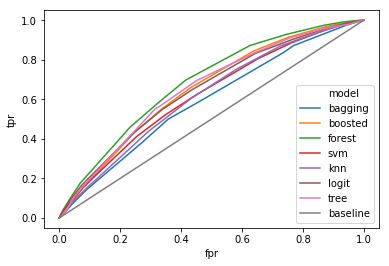

In [16]:
pl.compare_models(x_data=x, x_data_scaled=x_scaled, y_data=y,
               x_test=x_t, x_test_scaled=x_t_scaled,
               y_test=y_t, use_test_data=True,
               run_svm=True,
               run_tree=True,
               run_boosted=True, 
               run_bagging=True,
               run_logit=True,
               run_a_forest=True,
               run_knn=True,
               mythresholds=[0, 1, 2, 5, 10, 20, 30, 50, 60, 70, 90, 95, 98, 99, 100],
               my_max_depth=10,
               my_n_estimators=200,
               num_n=16,
               mykernel='linear',
               my_max_bagging_samples=200,
               my_svc_tol=.0000001,
               my_svc_random_state=0,
               my_svc_C=0.01,
               split_name="split_2_max_depth_10")

************Bagged Tree
Returning test set performance:
Threshold:  0
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 10422]
 [    0  4442]]


Threshold:  1
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 10422]
 [    0  4442]]


Threshold:  2
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 10422]
 [    0  4442]]


Threshold:  5
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 10422]
 [    0  4442]]


Threshold:  10
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 731 9691]
 [ 168 4274]]


Threshold:  20
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 731 9691]
 [ 168 4274]]


Threshold:  30
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[2661 7761]
 [ 667 3775]]


Threshold:  50
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[5027 5395]
 [1550 2892]]


Threshold:  60
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[5027 5395]
 [1550 2892]]


Threshold:  70
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[7203 3219]
 [2560 1882]]


Threshold:  90
confusi

confusion matrix
|T neg, F pos|
|F neg, T pos|
[[10066   356]
 [ 4054   388]]


Threshold:  98
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[10289   133]
 [ 4277   165]]


Threshold:  99
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[10355    67]
 [ 4360    82]]


Threshold:  100
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[10422     0]
 [ 4441     1]]


Threshold:  100
***************Tree model
Returning test set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 10422]
 [    0  4442]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 10422]
 [    0  4442]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 10422]
 [    0  4442]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 10422]
 [    0  4442]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 10422]
 [    0  4442]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 10422]
 [    0  4442]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 10422]
 [    0  4442]]




C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


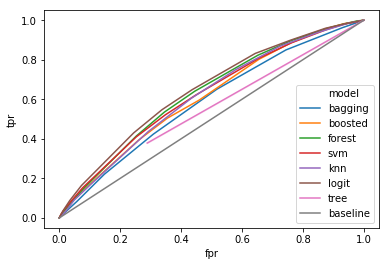

In [17]:
pl.compare_models(x_data=x, x_data_scaled=x_scaled, y_data=y,
               x_test=x_t, x_test_scaled=x_t_scaled,
               y_test=y_t, use_test_data=True,
               run_svm=True,
               run_tree=True,
               run_boosted=True, 
               run_bagging=True,
               run_logit=True,
               run_a_forest=True,
               run_knn=True,
               mythresholds=[0, 1, 2, 5, 10, 20, 30, 50, 60, 70, 90, 95, 98, 99, 100],
               my_max_depth=50,
               my_n_estimators=200,
               num_n=16,
               mykernel='linear',
               my_max_bagging_samples=200,
               my_svc_tol=.0000001,
               my_svc_random_state=0,
               my_svc_C=0.01,
               split_name="split_2_max_depth_50")

## Third training/test split

In [18]:
date_subset = test_set_ranges[2]
train, test = pl.split_using_date(projects,
                               train_start_date=date_subset[0],
                               train_end_date=date_subset[1],
                               test_start_date=date_subset[2],
                               test_end_date=date_subset[3])
print('training start and end dates are ', date_subset[:2], '\ntraining data dimensions:', train.shape)

train = make_dummies_subset_df(train, cat_vars, vars_to_keep)
test = make_dummies_subset_df(test, cat_vars, vars_to_keep)

# Fill missing values
pl.fill_missing(train, imputation_method='median')
pl.fill_missing(test, imputation_method='median')

# Split our training and test sets into x and y variables:
x, x_t = (train.drop(['60_day_outcome', 'date_posted'], axis=1),
          test.drop(['60_day_outcome', 'date_posted'], axis=1))
scaling = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(x)
x_scaled = scaling.transform(x)
scaling = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(x_t)
x_t_scaled = scaling.transform(x_t)
y, y_t = (train['60_day_outcome'], test['60_day_outcome'])

print('mean of 60 day outcome in training set:', round(y.mean(), 2))


training start and end dates are  ('2012-01-01', '2013-04-30') 
training data dimensions: (74241, 27)
mean of 60 day outcome in training set: 0.28


************Bagged Tree
Returning test set performance:
Threshold:  0
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 22855]
 [    0  8252]]


Threshold:  1
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[  167 22688]
 [   34  8218]]


Threshold:  2
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[  503 22352]
 [   82  8170]]


Threshold:  5
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 1345 21510]
 [  198  8054]]


Threshold:  10
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 2352 20503]
 [  438  7814]]


Threshold:  20
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 5222 17633]
 [  975  7277]]


Threshold:  30
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 7336 15519]
 [ 1705  6547]]


Threshold:  50
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[12224 10631]
 [ 3293  4959]]


Threshold:  60
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[14331  8524]
 [ 4103  4149]]


Threshold:  70
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[16691  6164]
 [ 5077  3175]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[14884  7971]
 [ 3780  4472]]


Threshold:  70
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[17029  5826]
 [ 4746  3506]]


Threshold:  90
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[21014  1841]
 [ 6982  1270]]


Threshold:  95
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[21927   928]
 [ 7624   628]]


Threshold:  98
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[22477   378]
 [ 8007   245]]


Threshold:  99
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[22678   177]
 [ 8117   135]]


Threshold:  100
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[22854     1]
 [ 8252     0]]


Threshold:  100
***************Tree model
Returning test set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 22855]
 [    0  8252]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 22855]
 [    0  8252]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[  335 22520]
 [   86  8166]]


confusion matrix
|T neg, F pos|
|F 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


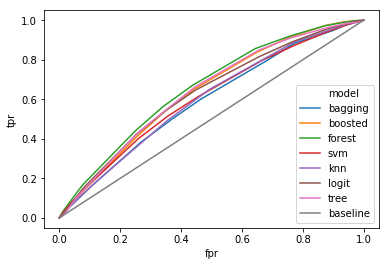

In [19]:
pl.compare_models(x_data=x, x_data_scaled=x_scaled, y_data=y,
               x_test=x_t, x_test_scaled=x_t_scaled,
               y_test=y_t, use_test_data=True,
               run_svm=True,
               run_tree=True,
               run_boosted=True, 
               run_bagging=True,
               run_logit=True,
               run_a_forest=True,
               run_knn=True,
               mythresholds=[0, 1, 2, 5, 10, 20, 30, 50, 60, 70, 90, 95, 98, 99, 100],
               my_max_depth=10,
               my_n_estimators=200,
               num_n=16,
               mykernel='linear',
               my_max_bagging_samples=200,
               my_svc_tol=.0000001,
               my_svc_random_state=0,
               my_svc_C=0.01,
               split_name="split_3_max_depth_10")

************Bagged Tree
Returning test set performance:
Threshold:  0
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 22855]
 [    0  8252]]


Threshold:  1
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 22855]
 [    0  8252]]


Threshold:  2
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 22855]
 [    0  8252]]


Threshold:  5
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 22855]
 [    0  8252]]


Threshold:  10
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 1764 21091]
 [  260  7992]]


Threshold:  20
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 1764 21091]
 [  260  7992]]


Threshold:  30
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[ 5420 17435]
 [ 1021  7231]]


Threshold:  50
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[10050 12805]
 [ 2397  5855]]


Threshold:  60
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[10050 12805]
 [ 2397  5855]]


Threshold:  70
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[14849  8006]
 [ 4163  4089]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[14884  7971]
 [ 3780  4472]]


Threshold:  70
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[17029  5826]
 [ 4746  3506]]


Threshold:  90
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[21014  1841]
 [ 6982  1270]]


Threshold:  95
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[21927   928]
 [ 7624   628]]


Threshold:  98
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[22477   378]
 [ 8007   245]]


Threshold:  99
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[22678   177]
 [ 8117   135]]


Threshold:  100
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[22854     1]
 [ 8252     0]]


Threshold:  100
***************Tree model
Returning test set performance:
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 22855]
 [    0  8252]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 22855]
 [    0  8252]]


confusion matrix
|T neg, F pos|
|F neg, T pos|
[[    0 22855]
 [    0  8252]]


confusion matrix
|T neg, F pos|
|F 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


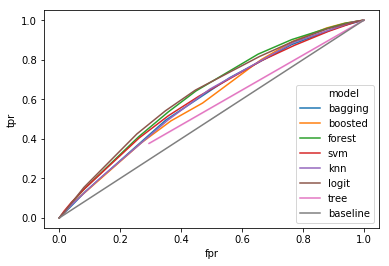

In [20]:
pl.compare_models(x_data=x, x_data_scaled=x_scaled, y_data=y,
               x_test=x_t, x_test_scaled=x_t_scaled,
               y_test=y_t, use_test_data=True,
               run_svm=True,
               run_tree=True,
               run_boosted=True, 
               run_bagging=True,
               run_logit=True,
               run_a_forest=True,
               run_knn=True,
               mythresholds=[0, 1, 2, 5, 10, 20, 30, 50, 60, 70, 90, 95, 98, 99, 100],
               my_max_depth=50,
               my_n_estimators=200,
               num_n=16,
               mykernel='linear',
               my_max_bagging_samples=200,
               my_svc_tol=.0000001,
               my_svc_random_state=0,
               my_svc_C=0.01,
               split_name="split_3_max_depth_50")